In [ ]:
!pip install --upgrade diffusers transformers scipy
!pip install accelerate
!pip install pillow
!pip install sentence_transformers

In [ ]:
!huggingface-cli login

In [15]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
import tensorflow as tf
from PIL import Image
import numpy as np

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

In [2]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)
pipe = pipe.to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [3]:
VGG16 = tf.keras.applications.VGG16(include_top=True, weights='imagenet')
x = VGG16.layers[-2].output
VGG16_MODEL = tf.keras.Model(inputs = VGG16.input, outputs = x)
VGG16_MODEL.trainable = False
VGG16_MODEL.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# generate image from stable-diffusion
def get_image_stable_diffusion(prompt):
  with autocast("cuda"):
    image = pipe(prompt, guidance_scale=7.5) 
    
  # image.save("image.png")
  img = image.images[0]
  return img

In [5]:
from tensorflow.keras.utils import img_to_array
# generate two images to compare
def get_images(prompt1, prompt2):
  size = 224, 224
  img1 = get_image_stable_diffusion(prompt1)
  img2 = get_image_stable_diffusion(prompt2)
  img1.thumbnail(size)
  img2.thumbnail(size)
  np_img1 = img_to_array(img1)
  np_img2 = img_to_array(img2)
  return img1, img2, np_img1, np_img2

## Images generated with same prompts

In [6]:
same_img1, same_img2, same_np_img1, same_np_img2 = get_images("A painting of a baby riding a bike", "A painting of a baby riding a bike")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

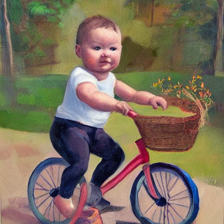

In [7]:
same_img1

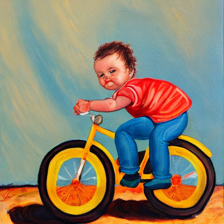

In [8]:
same_img2

## Images generated with different prompts

In [9]:
diff_img1, diff_img2, diff_np_img1, diff_np_img2 = get_images("A painting of a baby riding a bike", "Painting of a baby riding a bike")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

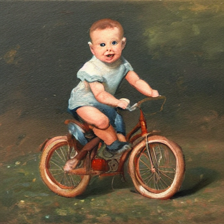

In [10]:
diff_img1

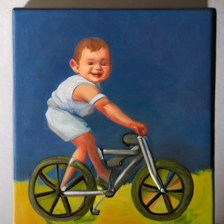

In [11]:
diff_img2

# L2 Norm

In [12]:
# Helper functions
def image_to_feature_vector(img):
    return np.array(tf.squeeze(VGG16_MODEL(tf.expand_dims(img, 0))))

from numpy.linalg import norm
def similarity(v1, v2):
    v1 /= norm(v1)
    v2 /= norm(v2)
    return 1. - norm(v2 - v1)

In [13]:
def get_similarity(img1, img2):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  image1 = tf.image.resize_with_pad(img1, 224, 224)
  # Normalize
  image1 = tf.math.divide(image1, 255.)
  image1 = tf.math.subtract(image1, mean)
  image1 = tf.math.divide(image1, std)
  image1 = image_to_feature_vector(image1)

  image2 = tf.image.resize_with_pad(img2, 224, 224)
  # Normalize
  image2 = tf.math.divide(image2, 255.)
  image2 = tf.math.subtract(image2, mean)
  image2 = tf.math.divide(image2, std)
  image2 = image_to_feature_vector(image2)

  sim = similarity(image1, image2)
  return sim

In [16]:
same_sim = get_similarity(same_np_img1, same_np_img2)

In [17]:
print("Similarity score for images generated using same prompt:", same_sim)

Similarity score for images generated using same prompt: 0.7670556306838989


In [18]:
diff_sim = get_similarity(diff_np_img1, diff_np_img2)

In [19]:
print("Similarity score for images generated using different prompt:", diff_sim)

Similarity score for images generated using different prompt: 0.6705344617366791


# Using CLIP Model's dense representations 

In [20]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import os

# Load the OpenAI CLIP Model
print('Loading CLIP Model...')
model = SentenceTransformer('clip-ViT-B-32')

Loading CLIP Model...


ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [21]:
def get_clip_similarity(img1, img2):
  encoded_image = model.encode([img1, img2], batch_size=128, convert_to_tensor=True, show_progress_bar=True)
  processed_images = util.paraphrase_mining_embeddings(encoded_image) 
  return processed_images[0][0]

In [22]:
same_sim = get_clip_similarity(same_img1, same_img2)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
print("Similarity score for images generated using same prompt:", same_sim)

Similarity score for images generated using same prompt: 0.9050304889678955


In [24]:
diff_sim = get_clip_similarity(diff_img1, diff_img2)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
print("Similarity score for images generated using different prompt:", diff_sim)

Similarity score for images generated using different prompt: 0.9062479734420776
